In [1]:
# Dataset Preparation

import numpy as np
import pandas as pd

# Parameters
n_samples = 1000
time = np.arange(n_samples)

# Features: sinusoidal + trend + noise
feature1 = np.sin(0.02 * time) + 0.1 * np.random.randn(n_samples)   # seasonal
feature2 = np.cos(0.02 * time) + 0.1 * np.random.randn(n_samples)   # seasonal
feature3 = 0.05 * time + 0.5 * np.random.randn(n_samples)           # trend
feature4 = np.sin(0.05 * time) + np.cos(0.01 * time)                # interaction

df = pd.DataFrame({
    "feature1": feature1,
    "feature2": feature2,
    "feature3": feature3,
    "feature4": feature4
})

# Target: weighted combination
df["target"] = 0.3*feature1 + 0.2*feature2 + 0.4*feature3 + 0.1*feature4 + 0.1*np.random.randn(n_samples)

print(df.head())

   feature1  feature2  feature3  feature4    target
0 -0.054616  1.028373 -0.102061  1.000000  0.342865
1 -0.061703  0.892474 -0.346723  1.049929  0.050398
2  0.011304  1.055477  0.200911  1.099633  0.439474
3 -0.039574  1.076219 -0.209452  1.148988  0.379064
4  0.132981  1.074606  1.012538  1.197869  0.859454


In [2]:
# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

X, y = [], []
window_size = 24   # past 24 steps
forecast_horizon = 24  # predict next 24 steps

for i in range(len(scaled) - window_size - forecast_horizon):
    X.append(scaled[i:i+window_size, :-1])   # features only
    y.append(scaled[i+window_size:i+window_size+forecast_horizon, -1])  # target

X, y = np.array(X), np.array(y)
print("Shape of X:", X.shape, "Shape of y:", y.shape)

Shape of X: (952, 24, 4) Shape of y: (952, 24)


In [3]:
# LSTM Model Implementation
import tensorflow as tf
from tensorflow.keras import layers, models

def build_lstm(input_shape, output_steps):
    model = models.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        layers.LSTM(32),
        layers.Dense(output_steps)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

model = build_lstm((window_size, X.shape[2]), forecast_horizon)
model.summary()

history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,872 (120.59 KB)

 Trainable params: 30,872 (120.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.1928 - mae: 0.3686 - val_loss: 0.2197 - val_mae: 0.4496
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0283 - mae: 0.1312 - val_loss: 0.0266 - val_mae: 0.1366
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0039 - mae: 0.0452 - val_loss: 0.0149 - val_mae: 0.1066
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.2825e-04 - mae: 0.0235 - val_loss: 0.0118 - val_mae: 0.0960
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.2314e-04 - mae: 0.0180 - val_loss: 0.0107 - val_mae: 0.0917
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.7122e-04 - mae: 0.0153 - val_loss: 0.0094 - val_mae: 0.0859
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.9579e-04 - mae: 0.0137 - val_loss: 0.0090 - val_mae: 0.0837
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.6232e-04 - mae: 0.0128 - val_loss: 0.0095 - val_mae: 0.0875
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42m

In [6]:
# Hyperparameter Tuning
import tensorflow as tf
from tensorflow.keras import layers, models

# Install Optuna if not already installed
try:
    import optuna
except ImportError:
    !pip install optuna
    import optuna

def objective(trial):
    units1 = trial.suggest_int("units1", 32, 128)
    units2 = trial.suggest_int("units2", 16, 64)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    model = models.Sequential([
        layers.LSTM(units1, return_sequences=True, input_shape=(window_size, X.shape[2])),
        layers.LSTM(units2),
        layers.Dense(forecast_horizon)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mae"])
    history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    return min(history.history["val_loss"])


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 26.6 MB/s eta 0:00:00


[I 2026-02-05 16:08:55,933] A new study created in memory with name: no-name-a38197dd-81cf-413c-af50-fdb2f00f5cc7
/tmp/ipython-input-1456424543.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2026-02-05 16:09:06,486] Trial 0 finished with value: 0.028361443430185318 and parameters: {'units1': 44, 'units2': 31, 'lr': 0.00015767710618605518}. Best is trial 0 with value: 0.028361443430185318.
[I 2026-02-05 16:09:17,663] Trial 1 finished with value: 0.010743891820311546 and parameters: {'units1':

Best hyperparameters: {'units1': 49, 'units2': 29, 'lr': 0.009950540532882746}


598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


PermutationExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


PermutationExplainer explainer:  30%|███       | 3/10 [00:28<00:45,  6.53s/it]

598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


PermutationExplainer explainer:  40%|████      | 4/10 [00:42<00:55,  9.33s/it]

598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


PermutationExplainer explainer:  50%|█████     | 5/10 [01:00<01:02, 12.58s/it]

598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


PermutationExplainer explainer:  60%|██████    | 6/10 [01:13<00:50, 12.65s/it]

598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


PermutationExplainer explainer:  70%|███████   | 7/10 [01:33<00:45, 15.27s/it]

598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


PermutationExplainer explainer:  80%|████████  | 8/10 [01:46<00:28, 14.38s/it]

598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


PermutationExplainer explainer:  90%|█████████ | 9/10 [01:58<00:13, 13.80s/it]

598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


PermutationExplainer explainer: 100%|██████████| 10/10 [02:15<00:00, 14.91s/it]

598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


PermutationExplainer explainer: 11it [02:28, 14.85s/it]
/tmp/ipython-input-3902498990.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X[:10].reshape(10, -1), feature_names=flattened_feature_names)


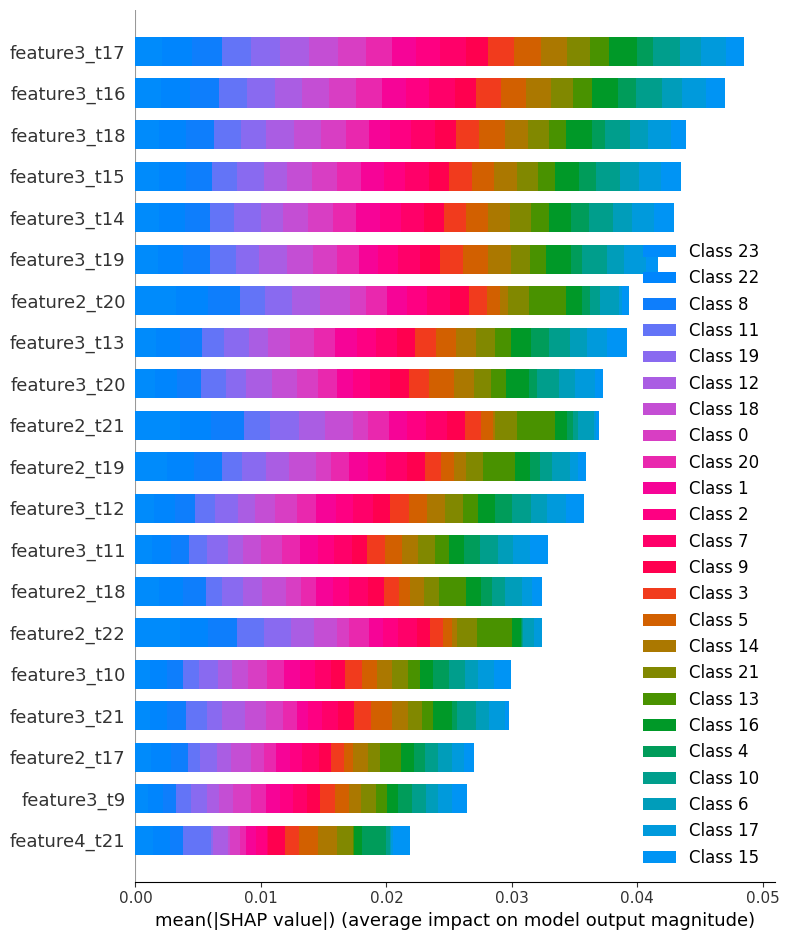

In [10]:
# Explainability with SHAP
import shap
import numpy as np

# Define a wrapper for the model.predict function to handle flattened input
# The original model expects (batch_size, window_size, num_features)
# The SHAP masker will provide (batch_size, window_size * num_features)
def wrapped_model_predict(flattened_input):
    # Reshape the flattened input back to (batch_size, window_size, num_features)
    # X.shape[2] is num_features, window_size is also defined in previous cells
    reshaped_input = flattened_input.reshape(-1, window_size, X.shape[2])
    return model.predict(reshaped_input)

# Create an explicit masker with a flattened background dataset
# X[:100] has shape (100, window_size, X.shape[2])
# Flatten it to (100, window_size * X.shape[2])
masker = shap.maskers.Independent(X[:100].reshape(100, -1))

# Use shap.Explainer with the wrapped model prediction function and the flattened masker
explainer = shap.Explainer(wrapped_model_predict, masker)

# Compute SHAP values for a flattened version of X[:10]
shap_values = explainer(X[:10].reshape(10, -1))

# For plotting, feature names also need to match the flattened input
# This will create names like 'feature1_t0', 'feature1_t1', ..., 'feature4_t23'
original_feature_names = df.columns[:-1] # ['feature1', 'feature2', 'feature3', 'feature4']
flattened_feature_names = []
for t in range(window_size):
    for f_name in original_feature_names:
        flattened_feature_names.append(f_name + f'_t{t}')

# Plot feature importance
shap.summary_plot(shap_values, X[:10].reshape(10, -1), feature_names=flattened_feature_names)

In [11]:
# Reporting & Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y.flatten(), y_pred.flatten()))
mae = mean_absolute_error(y.flatten(), y_pred.flatten())
mape = np.mean(np.abs((y.flatten() - y_pred.flatten()) / y.flatten())) * 100

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 0.0424, MAE: 0.0248, MAPE: 5.22%
